# Imports

In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.append('/home/hice1/mbibars3/scratch/vlm-debiasing/VLM-Debiasing-Project/scripts')

In [3]:
%autoreload 2
import pandas as pd
import numpy as np
import os
import model as m
import torch
import torch.nn as nn
import torch.optim as optim
import loaders
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

/home/hice1/mbibars3/scratch/miniconda3/envs/vlm-debiasing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [453]:
"""
seed = random.randint(1,100)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
"""

In [4]:
import random

def mixup_data(x1, x2, y1, y2, alpha=1.0):
    """
    Perform MixUp between two samples.
    
    Args:
        x1: The first sample (input tensor).
        x2: The second sample (input tensor).
        y1: The first label.
        y2: The second label.
        alpha: The mixing parameter (lambda), which controls the weight of each sample.

    Returns:
        mixed_x: The mixed input tensor.
        mixed_y: The mixed label tensor.
        lambda_value: The value of lambda (how much of each sample is mixed).
    """
    # Generate the mixing factor lambda from a Beta distribution
    lambda_value = torch.distributions.Beta(alpha, alpha).sample().item()

    # Perform MixUp for inputs
    mixed_x = lambda_value * x1 + (1 - lambda_value) * x2
    
    # Perform MixUp for labels
    mixed_y = lambda_value * y1 + (1 - lambda_value) * y2
    
    return mixed_x, mixed_y, lambda_value


In [5]:
import torch
import torch.nn as nn
return_lstm_output =False
class DeepConvLSTM(nn.Module):
    def __init__(self, input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size, dropout=0.5):
        """
        Args:
            input_channels: Number of input features (25 for your data).
            conv_channels: Number of output channels for the convolutional layers.
            lstm_hidden_size: Hidden size of the LSTM.
            lstm_layers: Number of LSTM layers.
            output_size: Size of the model output (e.g., number of classes for classification or 1 for regression).
            dropout: Dropout rate.
        """
        super(DeepConvLSTM, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(input_channels, conv_channels, kernel_size=9, stride=1, padding=2)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=9, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(conv_channels)
        self.bn2 = nn.BatchNorm1d(conv_channels)
        self.relu = nn.LeakyReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.2)
        # LSTM layers
        self.lstm = nn.LSTM(input_size=conv_channels, 
                            hidden_size=lstm_hidden_size, 
                            num_layers=lstm_layers, 
                            batch_first=True, 
                            dropout=dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        #nn.init.xavier_uniform_(self.conv1.weight)
        #nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc.weight)

        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='leaky_relu')
    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, time_steps, features).
        
        Returns:
            Output tensor.
        """
        # Input shape: (batch_size, time_steps, features)
        # Permute to match Conv1d input: (batch_size, features, time_steps)
        x = x.permute(0, 2, 1)
        
        # Pass through convolutional layers
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)  # Shape: (batch_size, conv_channels, reduced_time_steps)
        
        # Permute back for LSTM: (batch_size, reduced_time_steps, conv_channels)
        x = x.permute(0, 2, 1)
        
        # Pass through LSTM
        x, (h_n, c_n) = self.lstm(x)
        # Optionally return the LSTM embeddings
        if return_lstm_output:
            return x
        
        # Take the output of the last time step: (batch_size, lstm_hidden_size)
        x = x[:, -1, :]
        
        # Pass through fully connected layer
        x = self.fc(x)
        
        return x


In [6]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class PatientAudioDatasetCSV(Dataset):
    def __init__(self, dataframe, input_column, label_column=None, normalize=True):
        """
        Args:
            dataframe: DataFrame containing file paths and labels.
            input_column: Column name containing paths to the CSV files.
            label_column: Column name containing labels (if supervised learning).
            normalize: Whether to normalize the data (0-1 scaling).
        """
        self.dataframe = dataframe
        self.input_column = input_column
        self.label_column = label_column
        self.normalize = normalize

        # Compute normalization statistics (if enabled)
        if self.normalize:
            self.mean, self.std = self._compute_normalization_stats()
    
    def _compute_normalization_stats(self):
        """Compute mean and standard deviation across all data in the train split."""
        all_data = []
        for path in self.dataframe[self.input_column]:
            audio_data = np.load(path, allow_pickle=True)
            all_data.append(audio_data)
        all_data = np.concatenate(all_data, axis=0)
        return all_data.mean(axis=0), all_data.std(axis=0)

    def _normalize(self, data):
        """Normalize data using computed mean and std."""
        return (data - self.mean) / self.std

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Load audio data from CSV
        audio_path = row[self.input_column]
        audio_data = np.load(audio_path, allow_pickle=True).astype(np.float32)

        # Normalize if required
        if self.normalize:
            audio_data = self._normalize(audio_data)

        # Convert to tensor
        audio_tensor = torch.tensor(audio_data)

        # Load label if available
        if self.label_column:
            label = torch.tensor(row[self.label_column], dtype=torch.float32)
            return audio_tensor, label
        else:
            return audio_tensor


# 2D Text

In [7]:
fle = np.load("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/untarred/301_P/301_AUDIO_ast9.npy")
fle.shape

(1214, 768)

In [8]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/2d_audio_text_paths.csv")

In [9]:
features_csv.head()

,split,PTSD_severity,PTSD_label,gender,audio,text
0,train,22.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,23.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,train,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,train,67.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,39.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [10]:
input_column = 'text'
label_column = 'PTSD_label'

train_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="train"], input_column=input_column, label_column=label_column, normalize=True)
dev_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="dev"], input_column=input_column, label_column=label_column, normalize=True)


In [11]:
from torch.utils.data import DataLoader

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

i = 0
for batch_data, batch_labels in train_dataloader:
    print(f"Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")
    i+=1
    if i == 2:
        break



Data Shape: torch.Size([10, 768, 80]), Labels Shape: torch.Size([10])
Data Shape: torch.Size([10, 768, 80]), Labels Shape: torch.Size([10])


### w bn

In [308]:
input_channels = 80  # Number of input features per time step
conv_channels = 64   # Number of convolutional filters
lstm_hidden_size = 128  # LSTM hidden size
lstm_layers = 2      # Number of LSTM layers
output_size = 1     # Number of classes for classification (or 1 for regression)

model = DeepConvLSTM(input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size)


In [309]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

314881

In [310]:
learning_rate = 0.001
num_epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [311]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [312]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([114,  49])
tensor(2.3265)


In [313]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        _btch, labels = batch
        optimizer.zero_grad()
        inputs = _btch
        output = model(inputs)
        """
        print(inputs.shape)
        print(output.shape)
        print(labels.shape)
        """
        labels = labels.view(output.shape)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        preds = (torch.sigmoid(output) > 0.5).int()
        #print(np.unique(preds.detach().numpy()))
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            _btch, labels = batch

            # Forward pass
            inputs = _btch
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            #loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')
    # Check if this is the best model
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("best dev f1 ", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_text_model.pth")  # Save best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


best dev f1  0 :  0.1413894324853229
Epoch [1/50], Train Loss: 0.9658, Val Loss: 0.9741, Train F1: 0.5487, Val F1: 0.1414
Epoch [2/50], Train Loss: 0.9612, Val Loss: 0.9738, Train F1: 0.5534, Val F1: 0.1414
best dev f1  2 :  0.5718045112781954
Epoch [3/50], Train Loss: 0.9602, Val Loss: 0.9741, Train F1: 0.6140, Val F1: 0.5718
Epoch [4/50], Train Loss: 0.9619, Val Loss: 0.9737, Train F1: 0.5836, Val F1: 0.5718
Epoch [5/50], Train Loss: 0.9607, Val Loss: 0.9737, Train F1: 0.5757, Val F1: 0.5718
Epoch [6/50], Train Loss: 0.9619, Val Loss: 0.9738, Train F1: 0.5784, Val F1: 0.5718
Epoch [7/50], Train Loss: 0.9593, Val Loss: 0.9738, Train F1: 0.6169, Val F1: 0.5541
best dev f1  7 :  0.5856622280672914
Epoch [8/50], Train Loss: 0.9589, Val Loss: 0.9737, Train F1: 0.5784, Val F1: 0.5857
Epoch [9/50], Train Loss: 0.9413, Val Loss: 1.0035, Train F1: 0.6667, Val F1: 0.5718
Epoch [10/50], Train Loss: 0.9526, Val Loss: 0.9986, Train F1: 0.5736, Val F1: 0.1414
best dev f1  10 :  0.6116176967240797


In [314]:
model.load_state_dict(torch.load("best_text_model.pth", weights_only=True))

<All keys matched successfully>

In [315]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.7022067363530778


In [316]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
1.0


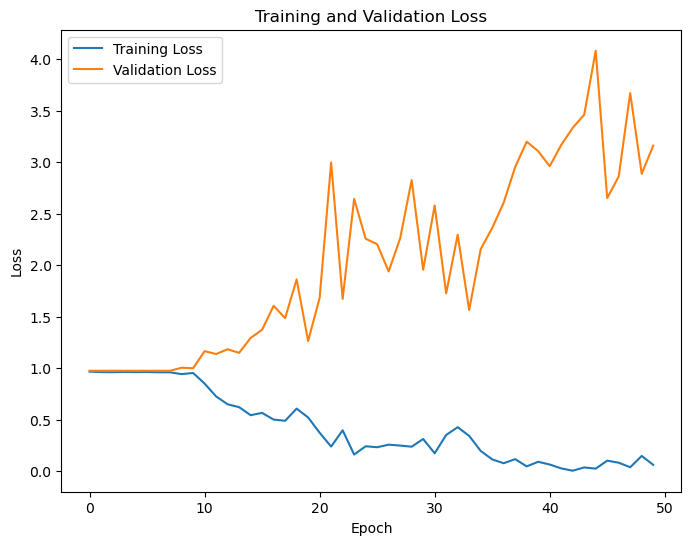

In [317]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [318]:
y_pred= out

In [319]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [320]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [321]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [322]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [323]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [324]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.10555555555555554


In [325]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.300000
1    0.194444
Name: selection_rate, dtype: float64


In [326]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 0.6481481481481481


### w/o bn

In [221]:
input_channels = 80  # Number of input features per time step
conv_channels = 64   # Number of convolutional filters
lstm_hidden_size = 128  # LSTM hidden size
lstm_layers = 2      # Number of LSTM layers
output_size = 1     # Number of classes for classification (or 1 for regression)

model = DeepConvLSTM(input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size)


In [222]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

314881

In [223]:
learning_rate = 0.001
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [224]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [225]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([114,  49])
tensor(2.3265)


In [226]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        _btch, labels = batch
        optimizer.zero_grad()
        inputs = _btch
        output = model(inputs)
        """
        print(inputs.shape)
        print(output.shape)
        print(labels.shape)
        """
        labels = labels.view(output.shape)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        preds = (torch.sigmoid(output) > 0.5).int()
        #print(np.unique(preds.detach().numpy()))
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            _btch, labels = batch

            # Forward pass
            inputs = _btch
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            #loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')
    # Check if this is the best model
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("best dev f1 ", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_text_model.pth")  # Save best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


best dev f1  0 :  0.5718045112781954
Epoch [1/50], Train Loss: 0.9603, Val Loss: 0.9751, Train F1: 0.5757, Val F1: 0.5718
Epoch [2/50], Train Loss: 0.9584, Val Loss: 0.9748, Train F1: 0.5757, Val F1: 0.5718
Epoch [3/50], Train Loss: 0.9583, Val Loss: 0.9747, Train F1: 0.5757, Val F1: 0.5718
Epoch [4/50], Train Loss: 0.9583, Val Loss: 0.9748, Train F1: 0.5757, Val F1: 0.5718
Epoch [5/50], Train Loss: 0.9578, Val Loss: 0.9749, Train F1: 0.5757, Val F1: 0.5718
Epoch [6/50], Train Loss: 0.9579, Val Loss: 0.9750, Train F1: 0.5757, Val F1: 0.5718
Epoch [7/50], Train Loss: 0.9575, Val Loss: 0.9751, Train F1: 0.5757, Val F1: 0.5718
Epoch [8/50], Train Loss: 0.9584, Val Loss: 0.9749, Train F1: 0.5757, Val F1: 0.5718
Epoch [9/50], Train Loss: 0.9592, Val Loss: 0.9752, Train F1: 0.5757, Val F1: 0.5718
Epoch [10/50], Train Loss: 0.9576, Val Loss: 0.9753, Train F1: 0.5757, Val F1: 0.5718
Epoch [11/50], Train Loss: 0.9573, Val Loss: 0.9754, Train F1: 0.5757, Val F1: 0.5718
Epoch [12/50], Train Loss:

In [227]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.5254280603117812


In [228]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
1.0


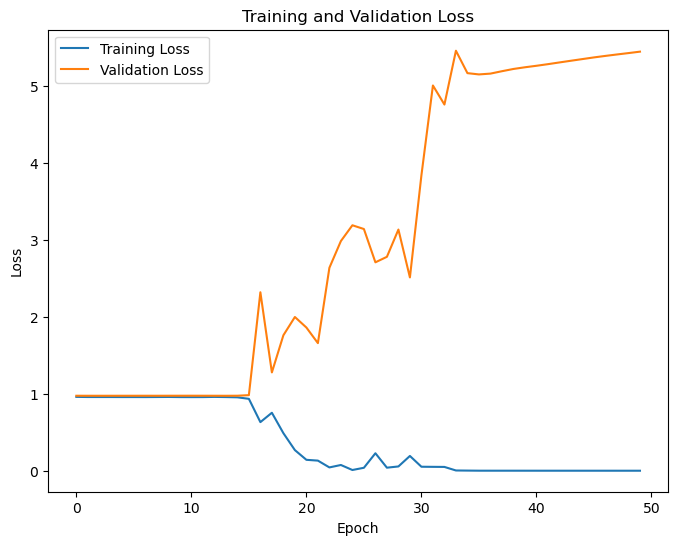

In [229]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [230]:
y_pred= out

In [231]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [232]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [233]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [234]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [235]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [236]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.061111111111111116


In [237]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.200000
1    0.138889
Name: selection_rate, dtype: float64


In [238]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

Demographic Parity Ratio: 0.6944444444444444


## Best model

In [156]:
model.load_state_dict(torch.load("best_text_model.pth", weights_only=True))

<All keys matched successfully>

In [157]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.6425954358294368


In [158]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.9938825022201148


In [159]:
y_pred= out

In [160]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [161]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [162]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [163]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [164]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [165]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.06666666666666667


In [166]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.150000
1    0.083333
Name: selection_rate, dtype: float64


In [167]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

Demographic Parity Ratio: 0.5555555555555556


# 2D Text Resampling Gender

In [58]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/undersampled_embeddings.csv")

In [59]:
features_csv.head()

,split,PTSD_severity,PTSD_label,gender,audio,text
0,train,51.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,26.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,test,49.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,test,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,21.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [60]:
input_column = 'text'
label_column = 'PTSD_label'

train_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="train"], input_column=input_column, label_column=label_column, normalize=True)
dev_dataset = PatientAudioDatasetCSV(features_csv[features_csv["split"]=="dev"], input_column=input_column, label_column=label_column, normalize=True)


In [61]:
from torch.utils.data import DataLoader

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)


for batch_data, batch_labels in train_dataloader:
    print(f"Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")
    break


Data Shape: torch.Size([10, 768, 80]), Labels Shape: torch.Size([10])


In [62]:
input_channels = 80  # Number of input features per time step
conv_channels = 64   # Number of convolutional filters
lstm_hidden_size = 128  # LSTM hidden size
lstm_layers = 2      # Number of LSTM layers
output_size = 1     # Number of classes for classification (or 1 for regression)

model = DeepConvLSTM(input_channels, conv_channels, lstm_hidden_size, lstm_layers, output_size)


In [63]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

314881

In [64]:
learning_rate = 0.001
num_epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [65]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [66]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([87, 42])
tensor(2.0714)


In [67]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        _btch, labels = batch
        optimizer.zero_grad()
        inputs = _btch
        output = model(inputs)
        """
        print(inputs.shape)
        print(output.shape)
        print(labels.shape)
        """
        labels = labels.view(output.shape)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        preds = (torch.sigmoid(output) > 0.5).int()
        #print(np.unique(preds.detach().numpy()))
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            _btch, labels = batch

            # Forward pass
            inputs = _btch
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            #loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')
    # Check if this is the best model
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("best dev f1 ", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_text_undersampled_model.pth")  # Save best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


best dev f1  0 :  0.5542594556380347
Epoch [1/50], Train Loss: 0.9439, Val Loss: 0.8833, Train F1: 0.5567, Val F1: 0.5543
Epoch [2/50], Train Loss: 0.9382, Val Loss: 0.8940, Train F1: 0.5234, Val F1: 0.1527
Epoch [3/50], Train Loss: 0.9365, Val Loss: 0.8866, Train F1: 0.2528, Val F1: 0.2249
Epoch [4/50], Train Loss: 0.9354, Val Loss: 0.8812, Train F1: 0.5784, Val F1: 0.5543
Epoch [5/50], Train Loss: 0.9356, Val Loss: 0.8812, Train F1: 0.5720, Val F1: 0.5543
Epoch [6/50], Train Loss: 0.9337, Val Loss: 0.8751, Train F1: 0.6252, Val F1: 0.5543
Epoch [7/50], Train Loss: 0.9120, Val Loss: 0.9115, Train F1: 0.6546, Val F1: 0.1695
Epoch [8/50], Train Loss: 0.8887, Val Loss: 1.0983, Train F1: 0.6725, Val F1: 0.1527
Epoch [9/50], Train Loss: 0.9214, Val Loss: 0.8922, Train F1: 0.5749, Val F1: 0.5423
Epoch [10/50], Train Loss: 0.9517, Val Loss: 0.9056, Train F1: 0.5428, Val F1: 0.1527
Epoch [11/50], Train Loss: 0.9180, Val Loss: 0.9020, Train F1: 0.2381, Val F1: 0.1436
Epoch [12/50], Train Loss:

In [68]:
model.load_state_dict(torch.load("best_text_undersampled_model.pth", weights_only=True))

<All keys matched successfully>

In [69]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.5626310561748152


In [70]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
1.0


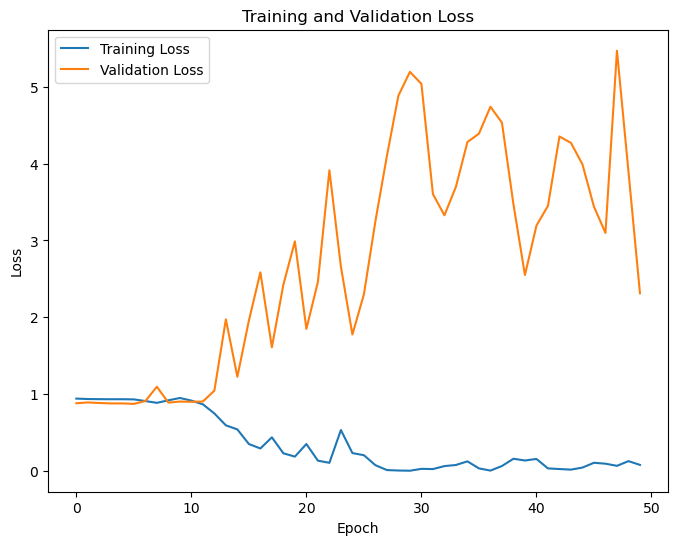

In [71]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [72]:
y_pred= out

In [73]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [74]:
np.unique(features_csv['gender'])

array(['female', 'male'], dtype=object)

In [75]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [76]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [77]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (41,)
Shape of y_test: (41,)
Shape of y_pred: (41,)


In [78]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.004761904761904773


In [79]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.100000
1    0.095238
Name: selection_rate, dtype: float64


In [80]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 0.9523809523809523


# Audio_Text_Model

In [86]:
class PatientMultiModalityDataset(Dataset):
    def __init__(self, dataframe, input_columns, label_column=None, normalize=True):
        """
        Args:
            dataframe: DataFrame containing file paths and labels.
            input_columns: List of column names, each containing paths to the modalities.
            label_column: Column name containing labels (if supervised learning).
            normalize: Whether to normalize the data for each modality (0-1 scaling per modality).
        """
        self.dataframe = dataframe
        self.input_columns = input_columns
        self.label_column = label_column
        self.normalize = normalize
        self.normalization_stats = self._compute_normalization_stats() if normalize else None

    def _compute_normalization_stats(self):
        """Compute normalization statistics (min/max) for each modality."""
        stats = {}
        for column in self.input_columns:
            all_data = []
            for path in self.dataframe[column]:
                modality_data = np.load(path, allow_pickle=True)
                all_data.append(modality_data)
            all_data = np.concatenate(all_data, axis=0)
            stats[column] = {
                "mean": all_data.mean(axis=0),
                "std": all_data.std(axis=0)
            }
        return stats

    def _normalize(self, data, column):
        """Normalize data using computed statistics for the given column."""
        mean = self.normalization_stats[column]["mean"]
        std = self.normalization_stats[column]["std"]
        return (data - mean) / (std + 1e-8)  # Add epsilon to avoid division by zero.

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Load all modalities
        modality_tensors = []
        for column in self.input_columns:
            modality_data = np.load(row[column], allow_pickle=True).astype(np.float32)
            if self.normalize:
                modality_data = self._normalize(modality_data, column)
            modality_tensors.append(torch.tensor(modality_data))

        # Load label if available
        if self.label_column:
            label = torch.tensor(row[self.label_column], dtype=torch.float32)
            return modality_tensors, label
        else:
            return modality_tensors

def collate_fn(batch):
    # Extract lists of modalities and labels from the batch
    batch_data, labels = zip(*batch)
    num_modalities = len(batch_data[0])
    #print(modalities[0])
    data = []

    # Stack each modality across batch dimension
    for i in range(num_modalities):
        #print(f"============modality_{i}================")
        samples = [sample[i] for sample in batch_data]

        #print(np.unique([sample[i] for sample in batch_data]))
        _modality = torch.stack(samples, dim=0)
        data.append(_modality)

    labels = torch.stack(labels)
    
    # Return in the desired format: data = [modality1, modality2, modality3], labels
    return data, labels

In [100]:
class MultiModalDeepConvLSTM(nn.Module):
    def __init__(self, modality_configs, lstm_hidden_size, lstm_layers, output_size, dropout=0.5):
        """
        Args:
            modality_configs: List of configs for each modality, where each config is a tuple
                              (input_channels, conv_channels).
            lstm_hidden_size: Hidden size of the LSTM.
            lstm_layers: Number of LSTM layers.
            output_size: Size of the model output (e.g., number of classes for classification).
            dropout: Dropout rate.
        """
        super(MultiModalDeepConvLSTM, self).__init__()
        
        self.modality_nets = nn.ModuleList()
        for input_channels, conv_channels in modality_configs:
            modality_net = nn.Sequential(
                nn.Conv1d(input_channels, conv_channels, kernel_size=9, stride=1, padding=2),
                nn.BatchNorm1d(conv_channels),
                nn.LeakyReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2),
                nn.Conv1d(conv_channels, conv_channels, kernel_size=9, stride=1, padding=2),
                nn.BatchNorm1d(conv_channels),
                nn.LeakyReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2),
            )
            self.modality_nets.append(modality_net)
        
        # LSTM to process concatenated features
        total_features = sum([conv_channels for _, conv_channels in modality_configs])
        self.lstm = nn.LSTM(input_size=total_features, 
                            hidden_size=lstm_hidden_size, 
                            num_layers=lstm_layers, 
                            batch_first=True, 
                            dropout=dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        nn.init.xavier_uniform_(self.fc.weight)
    
    def forward(self, modalities):
        """
        Args:
            modalities: List of input tensors, one for each modality.
                       Each tensor has shape (batch_size, time_steps, channels).
        
        Returns:
            Output tensor.
        """
        processed_modalities = []
        for i, modality in enumerate(modalities):
            # Permute to match Conv1d input: (batch_size, channels, time_steps)
            modality = modality.permute(0, 2, 1)
            processed = self.modality_nets[i](modality)  # Shape: (batch_size, conv_channels, reduced_time_steps)
            
            # Pool along the time dimension to align time steps
            processed = torch.mean(processed, dim=-1)  # Shape: (batch_size, conv_channels)
            processed_modalities.append(processed)
        
        # Concatenate processed features from all modalities
        concatenated = torch.cat(processed_modalities, dim=-1)  # Shape: (batch_size, total_features)
        
        # Add a time dimension for LSTM input: (batch_size, 1, total_features)
        lstm_input = concatenated.unsqueeze(1)
        
        # Pass through LSTM
        lstm_output, _ = self.lstm(lstm_input)
        
        # Take the output of the last time step: (batch_size, lstm_hidden_size)
        lstm_output = lstm_output[:, -1, :]
        
        # Fully connected layer
        output = self.fc(lstm_output)
        
        return output


In [82]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/2d_audio_text_paths.csv")

In [83]:
features_csv.head()

,split,PTSD_severity,PTSD_label,gender,audio,text
0,train,22.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,23.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,train,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,train,67.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,39.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [85]:
input_columns = ['audio','text']
label_column = 'PTSD_label'

train_dataset = PatientMultiModalityDataset(features_csv[features_csv["split"]=="train"], input_columns=input_columns, label_column=label_column, normalize=True)
dev_dataset = PatientMultiModalityDataset(features_csv[features_csv["split"]=="dev"], input_columns=input_columns, label_column=label_column, normalize=True)


In [91]:
from torch.utils.data import DataLoader

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

i = 0
for batch_data, batch_labels in train_dataloader:
    print(f"Len of data:{len(batch_data)}, len of labels: {len(batch_labels)}")
    for j,m in enumerate(batch_data):
        print(f"modality_{j} Data Shape: {m.shape}")
    i+=1
    if i == 2:
        break


Len of data:2, len of labels: 10
modality_0 Data Shape: torch.Size([10, 1214, 768])
modality_1 Data Shape: torch.Size([10, 768, 80])
Len of data:2, len of labels: 10
modality_0 Data Shape: torch.Size([10, 1214, 768])
modality_1 Data Shape: torch.Size([10, 768, 80])


## T1

In [108]:
# Example usage
model = MultiModalDeepConvLSTM(
    modality_configs=[(768, 512),(80, 512)],
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

In [109]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

9355393

In [110]:
learning_rate = 0.001
num_epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [111]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [112]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([114,  49])
tensor(2.3265)


In [114]:
from sklearn.metrics import f1_score

# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation F1 score

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    # Training Phase
    for batch in train_dataloader:
        modalities, labels = batch  # Unpack modalities and labels
        optimizer.zero_grad()

        # Concatenate modalities along the feature dimension (if required by the model)
        #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
        output = model(modalities)  # Forward pass through the model

        # Reshape labels to match the output shape
        labels = labels.view(output.shape)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Accumulate training loss
        running_train_loss += loss.item()

        # Convert logits to predictions (assuming binary classification)
        preds = (torch.sigmoid(output) > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch  # Unpack modalities and labels

            # Concatenate modalities along the feature dimension
            #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
            output = model(modalities)  # Forward pass

            # Reshape labels to match the output shape
            labels = labels.view(output.shape)

            # Compute validation loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

            # Convert logits to predictions
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training and validation
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Save the best model based on validation F1-score
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("Best Validation F1", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_multimodal_model.pth")  # Save the best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Best Validation F1 0 :  0.5029258469556976
Epoch [1/50], Train Loss: 0.9882, Val Loss: 0.9780, Train F1: 0.3062, Val F1: 0.5029
Best Validation F1 1 :  0.6785714285714286
Epoch [2/50], Train Loss: 0.9629, Val Loss: 0.9601, Train F1: 0.6125, Val F1: 0.6786
Epoch [3/50], Train Loss: 0.9111, Val Loss: 0.9549, Train F1: 0.6530, Val F1: 0.6202
Epoch [4/50], Train Loss: 0.8036, Val Loss: 1.1175, Train F1: 0.7619, Val F1: 0.5357
Best Validation F1 4 :  0.739430894308943
Epoch [5/50], Train Loss: 0.8775, Val Loss: 0.9155, Train F1: 0.7749, Val F1: 0.7394
Epoch [6/50], Train Loss: 0.8108, Val Loss: 0.8974, Train F1: 0.6225, Val F1: 0.6677
Epoch [7/50], Train Loss: 0.6404, Val Loss: 1.0389, Train F1: 0.8379, Val F1: 0.6481
Epoch [8/50], Train Loss: 0.6631, Val Loss: 1.0523, Train F1: 0.7750, Val F1: 0.6327
Epoch [9/50], Train Loss: 0.5904, Val Loss: 1.1802, Train F1: 0.8486, Val F1: 0.5543
Epoch [10/50], Train Loss: 0.5194, Val Loss: 1.2555, Train F1: 0.8385, Val F1: 0.6481
Epoch [11/50], Train 

In [116]:
model.load_state_dict(torch.load("best_multimodal_model.pth", weights_only=True))

<All keys matched successfully>

In [117]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.739430894308943


In [118]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.8151803082448003


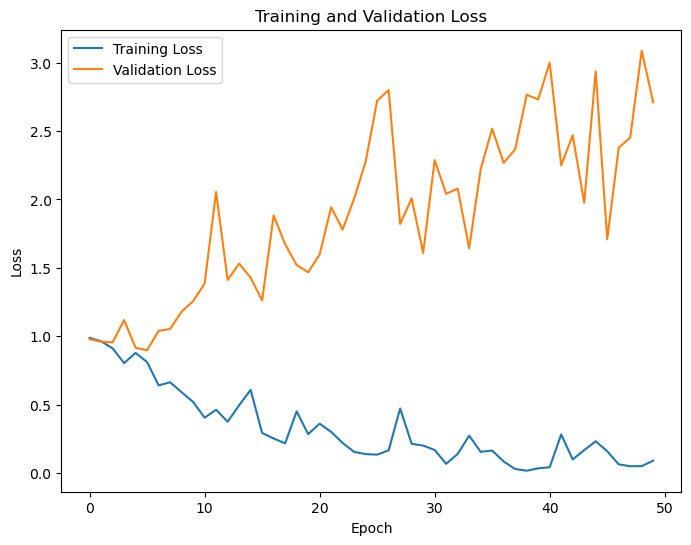

In [119]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [120]:
y_pred= out

In [121]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [122]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [123]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [124]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [125]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [126]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.04999999999999999


In [127]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.20
1    0.25
Name: selection_rate, dtype: float64


In [128]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 1.25
0.8


## T2

In [149]:
# Example usage
model = MultiModalDeepConvLSTM(
    modality_configs=[(768, 512),(80, 512)],
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

In [150]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

9355393

In [151]:
learning_rate = 0.001
num_epochs = 20
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [152]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [153]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([114,  49])
tensor(2.3265)


In [154]:
from sklearn.metrics import f1_score

# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation F1 score

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    # Training Phase
    for batch in train_dataloader:
        modalities, labels = batch  # Unpack modalities and labels
        optimizer.zero_grad()

        # Concatenate modalities along the feature dimension (if required by the model)
        #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
        output = model(modalities)  # Forward pass through the model

        # Reshape labels to match the output shape
        labels = labels.view(output.shape)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Accumulate training loss
        running_train_loss += loss.item()

        # Convert logits to predictions (assuming binary classification)
        preds = (torch.sigmoid(output) > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch  # Unpack modalities and labels

            # Concatenate modalities along the feature dimension
            #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
            output = model(modalities)  # Forward pass

            # Reshape labels to match the output shape
            labels = labels.view(output.shape)

            # Compute validation loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

            # Convert logits to predictions
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training and validation
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Save the best model based on validation F1-score
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("Best Validation F1", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_multimodal_model_t2.pth")  # Save the best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Best Validation F1 0 :  0.6116176967240797
Epoch [1/20], Train Loss: 0.9796, Val Loss: 0.9830, Train F1: 0.4933, Val F1: 0.6116
Epoch [2/20], Train Loss: 1.0062, Val Loss: 0.9669, Train F1: 0.5351, Val F1: 0.5977
Epoch [3/20], Train Loss: 0.9458, Val Loss: 0.9407, Train F1: 0.5557, Val F1: 0.6055
Best Validation F1 3 :  0.6361959957850368
Epoch [4/20], Train Loss: 0.8560, Val Loss: 0.9029, Train F1: 0.7451, Val F1: 0.6362
Epoch [5/20], Train Loss: 0.9004, Val Loss: 1.0323, Train F1: 0.7539, Val F1: 0.6129
Epoch [6/20], Train Loss: 0.7383, Val Loss: 1.1819, Train F1: 0.7603, Val F1: 0.5669
Best Validation F1 6 :  0.6725446428571429
Epoch [7/20], Train Loss: 0.6600, Val Loss: 0.9678, Train F1: 0.7731, Val F1: 0.6725
Best Validation F1 7 :  0.6908163265306122
Epoch [8/20], Train Loss: 0.6158, Val Loss: 0.9328, Train F1: 0.8357, Val F1: 0.6908
Best Validation F1 8 :  0.7142857142857143
Epoch [9/20], Train Loss: 0.6212, Val Loss: 0.9868, Train F1: 0.7872, Val F1: 0.7143
Epoch [10/20], Train

In [155]:
model.load_state_dict(torch.load("best_multimodal_model_t2.pth", weights_only=True))

<All keys matched successfully>

In [156]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.7142857142857143


In [157]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.9455064401285596


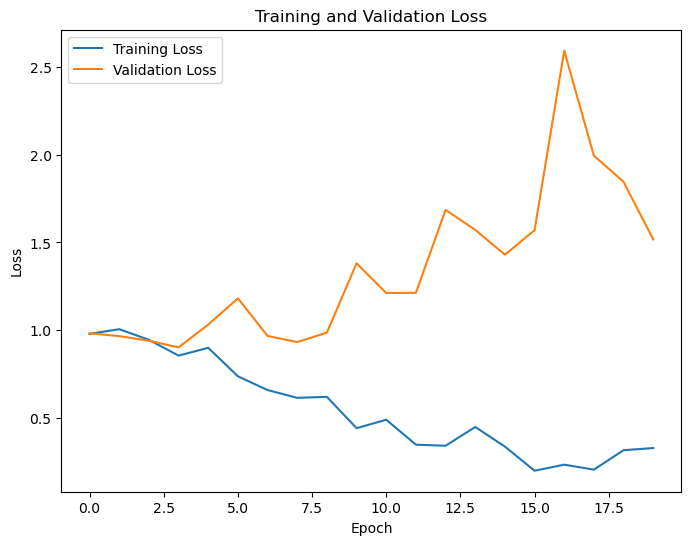

In [158]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [159]:
y_pred= out

In [160]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [161]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [162]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [163]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [164]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [165]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.07222222222222219


In [166]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.350000
1    0.277778
Name: selection_rate, dtype: float64


In [167]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 0.7936507936507937


## T3

In [179]:
# Example usage
model = MultiModalDeepConvLSTM(
    modality_configs=[(768, 512),(80, 512)],
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

In [180]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

9355393

In [181]:
learning_rate = 0.001
num_epochs = 20
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [182]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [183]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([114,  49])
tensor(2.3265)


In [184]:
from sklearn.metrics import f1_score

# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation F1 score

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    # Training Phase
    for batch in train_dataloader:
        modalities, labels = batch  # Unpack modalities and labels
        optimizer.zero_grad()

        # Concatenate modalities along the feature dimension (if required by the model)
        #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
        output = model(modalities)  # Forward pass through the model

        # Reshape labels to match the output shape
        labels = labels.view(output.shape)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Accumulate training loss
        running_train_loss += loss.item()

        # Convert logits to predictions (assuming binary classification)
        preds = (torch.sigmoid(output) > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch  # Unpack modalities and labels

            # Concatenate modalities along the feature dimension
            #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
            output = model(modalities)  # Forward pass

            # Reshape labels to match the output shape
            labels = labels.view(output.shape)

            # Compute validation loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

            # Convert logits to predictions
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training and validation
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Save the best model based on validation F1-score
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("Best Validation F1", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_multimodal_model_t3.pth")  # Save the best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Best Validation F1 0 :  0.6010793111811789
Epoch [1/20], Train Loss: 1.0100, Val Loss: 0.9668, Train F1: 0.5862, Val F1: 0.6011
Epoch [2/20], Train Loss: 0.9746, Val Loss: 0.9741, Train F1: 0.3704, Val F1: 0.4215
Epoch [3/20], Train Loss: 0.9381, Val Loss: 0.9691, Train F1: 0.6496, Val F1: 0.6005
Best Validation F1 3 :  0.6708439961864618
Epoch [4/20], Train Loss: 0.9060, Val Loss: 0.8877, Train F1: 0.6525, Val F1: 0.6708
Epoch [5/20], Train Loss: 0.9342, Val Loss: 0.9926, Train F1: 0.7037, Val F1: 0.6299
Epoch [6/20], Train Loss: 0.8278, Val Loss: 0.9267, Train F1: 0.7338, Val F1: 0.5878
Epoch [7/20], Train Loss: 0.7098, Val Loss: 1.3280, Train F1: 0.8083, Val F1: 0.5372
Epoch [8/20], Train Loss: 0.6686, Val Loss: 0.9577, Train F1: 0.8462, Val F1: 0.6172
Epoch [9/20], Train Loss: 0.6366, Val Loss: 1.1173, Train F1: 0.7863, Val F1: 0.6279
Best Validation F1 9 :  0.7609233657620754
Epoch [10/20], Train Loss: 0.6233, Val Loss: 0.9221, Train F1: 0.7970, Val F1: 0.7609
Epoch [11/20], Train

In [185]:
model.load_state_dict(torch.load("best_multimodal_model_t3.pth", weights_only=True))

<All keys matched successfully>

In [186]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.7609233657620754


In [187]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.9446212202603957


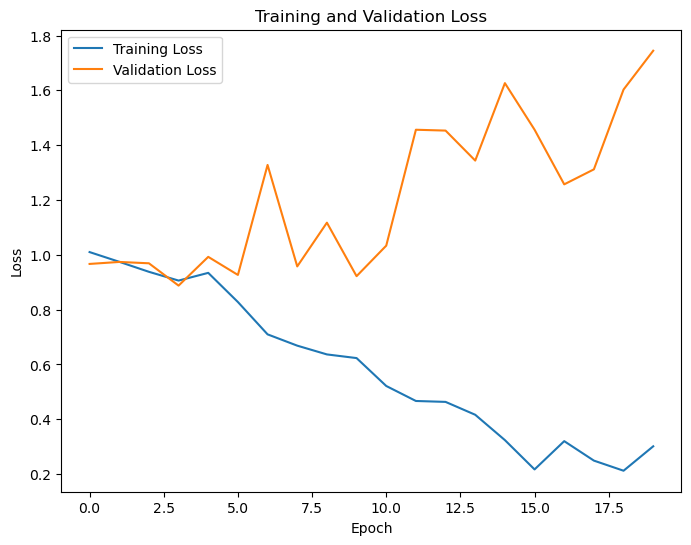

In [188]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [189]:
y_pred= out

In [190]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [191]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [192]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [193]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [194]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [195]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.07777777777777778


In [196]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.300000
1    0.222222
Name: selection_rate, dtype: float64


In [197]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 0.7407407407407407


## T4

In [198]:
# Example usage
model = MultiModalDeepConvLSTM(
    modality_configs=[(768, 128),(80, 128)],
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

In [199]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1603201

In [200]:
learning_rate = 0.001
num_epochs = 20
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [201]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [202]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([114,  49])
tensor(2.3265)


In [203]:
from sklearn.metrics import f1_score

# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation F1 score

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    # Training Phase
    for batch in train_dataloader:
        modalities, labels = batch  # Unpack modalities and labels
        optimizer.zero_grad()

        # Concatenate modalities along the feature dimension (if required by the model)
        #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
        output = model(modalities)  # Forward pass through the model

        # Reshape labels to match the output shape
        labels = labels.view(output.shape)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Accumulate training loss
        running_train_loss += loss.item()

        # Convert logits to predictions (assuming binary classification)
        preds = (torch.sigmoid(output) > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch  # Unpack modalities and labels

            # Concatenate modalities along the feature dimension
            #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
            output = model(modalities)  # Forward pass

            # Reshape labels to match the output shape
            labels = labels.view(output.shape)

            # Compute validation loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

            # Convert logits to predictions
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training and validation
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Save the best model based on validation F1-score
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("Best Validation F1", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_multimodal_model_t4.pth")  # Save the best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Best Validation F1 0 :  0.6226708074534162
Epoch [1/20], Train Loss: 0.9748, Val Loss: 0.9538, Train F1: 0.2932, Val F1: 0.6227
Best Validation F1 1 :  0.6868014631172527
Epoch [2/20], Train Loss: 0.9647, Val Loss: 0.9470, Train F1: 0.5726, Val F1: 0.6868
Best Validation F1 2 :  0.7376447876447878
Epoch [3/20], Train Loss: 0.9381, Val Loss: 0.8935, Train F1: 0.6470, Val F1: 0.7376
Epoch [4/20], Train Loss: 0.9382, Val Loss: 0.9869, Train F1: 0.6721, Val F1: 0.6172
Epoch [5/20], Train Loss: 0.7659, Val Loss: 0.8673, Train F1: 0.7177, Val F1: 0.7252
Epoch [6/20], Train Loss: 0.6760, Val Loss: 1.1332, Train F1: 0.8348, Val F1: 0.6385
Epoch [7/20], Train Loss: 0.4983, Val Loss: 1.0956, Train F1: 0.8436, Val F1: 0.6730
Epoch [8/20], Train Loss: 0.5081, Val Loss: 1.3008, Train F1: 0.8728, Val F1: 0.6217
Epoch [9/20], Train Loss: 0.4381, Val Loss: 1.0517, Train F1: 0.8850, Val F1: 0.6893
Epoch [10/20], Train Loss: 0.2818, Val Loss: 2.2095, Train F1: 0.9327, Val F1: 0.4847
Epoch [11/20], Train

In [204]:
model.load_state_dict(torch.load("best_multimodal_model_t4.pth", weights_only=True))

<All keys matched successfully>

In [205]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.7376447876447878


In [206]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.7611699820288778


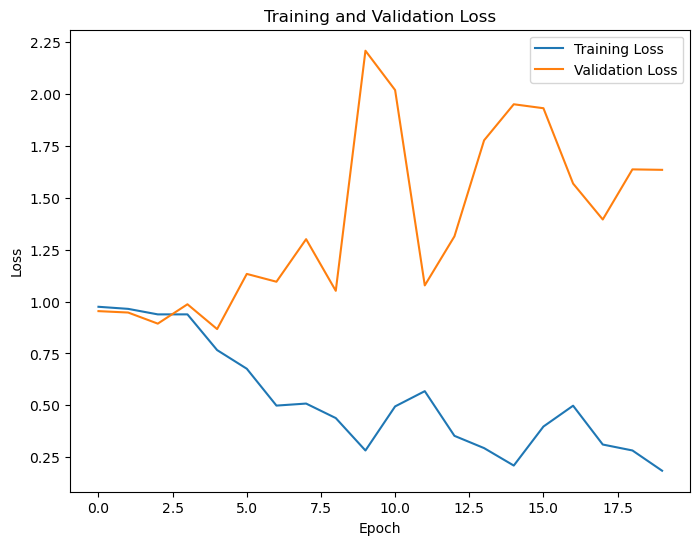

In [207]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [208]:
y_pred= out

In [209]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [210]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [211]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [212]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [213]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56,)


In [214]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.011111111111111127


In [215]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.350000
1    0.361111
Name: selection_rate, dtype: float64


In [216]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 1.0317460317460319
0.9692307692307691


# Audio_Text_Model resampling

In [217]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/undersampled_embeddings.csv")

In [218]:
features_csv.head()

,split,PTSD_severity,PTSD_label,gender,audio,text
0,train,51.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,26.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,test,49.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,test,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,21.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [219]:
input_columns = ['audio','text']
label_column = 'PTSD_label'

train_dataset = PatientMultiModalityDataset(features_csv[features_csv["split"]=="train"], input_columns=input_columns, label_column=label_column, normalize=True)
dev_dataset = PatientMultiModalityDataset(features_csv[features_csv["split"]=="dev"], input_columns=input_columns, label_column=label_column, normalize=True)


In [220]:
from torch.utils.data import DataLoader

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

i = 0
for batch_data, batch_labels in train_dataloader:
    print(f"Len of data:{len(batch_data)}, len of labels: {len(batch_labels)}")
    for j,m in enumerate(batch_data):
        print(f"modality_{j} Data Shape: {m.shape}")
    i+=1
    if i == 2:
        break


Len of data:2, len of labels: 10
modality_0 Data Shape: torch.Size([10, 1214, 768])
modality_1 Data Shape: torch.Size([10, 768, 80])
Len of data:2, len of labels: 10
modality_0 Data Shape: torch.Size([10, 1214, 768])
modality_1 Data Shape: torch.Size([10, 768, 80])


## T1

In [221]:
# Example usage
model = MultiModalDeepConvLSTM(
    modality_configs=[(768, 512),(80, 512)],
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

In [222]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

9355393

In [223]:
learning_rate = 0.001
num_epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [224]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [225]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([87, 42])
tensor(2.0714)


In [226]:
from sklearn.metrics import f1_score

# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation F1 score

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    # Training Phase
    for batch in train_dataloader:
        modalities, labels = batch  # Unpack modalities and labels
        optimizer.zero_grad()

        # Concatenate modalities along the feature dimension (if required by the model)
        #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
        output = model(modalities)  # Forward pass through the model

        # Reshape labels to match the output shape
        labels = labels.view(output.shape)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Accumulate training loss
        running_train_loss += loss.item()

        # Convert logits to predictions (assuming binary classification)
        preds = (torch.sigmoid(output) > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch  # Unpack modalities and labels

            # Concatenate modalities along the feature dimension
            #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
            output = model(modalities)  # Forward pass

            # Reshape labels to match the output shape
            labels = labels.view(output.shape)

            # Compute validation loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

            # Convert logits to predictions
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training and validation
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Save the best model based on validation F1-score
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("Best Validation F1", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_multimodal_model_t1_under.pth")  # Save the best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Best Validation F1 0 :  0.6792627745281978
Epoch [1/50], Train Loss: 0.9513, Val Loss: 0.8743, Train F1: 0.5111, Val F1: 0.6793
Epoch [2/50], Train Loss: 0.9176, Val Loss: 0.8897, Train F1: 0.5720, Val F1: 0.5227
Epoch [3/50], Train Loss: 0.9172, Val Loss: 0.9016, Train F1: 0.4313, Val F1: 0.4679
Epoch [4/50], Train Loss: 0.9016, Val Loss: 0.8703, Train F1: 0.6374, Val F1: 0.6165
Best Validation F1 4 :  0.7313139260424862
Epoch [5/50], Train Loss: 0.8399, Val Loss: 0.8558, Train F1: 0.7050, Val F1: 0.7313
Epoch [6/50], Train Loss: 0.7358, Val Loss: 1.0701, Train F1: 0.7688, Val F1: 0.5040
Epoch [7/50], Train Loss: 0.6961, Val Loss: 1.3211, Train F1: 0.7669, Val F1: 0.6165
Epoch [8/50], Train Loss: 0.4882, Val Loss: 1.3800, Train F1: 0.8908, Val F1: 0.5873
Epoch [9/50], Train Loss: 0.3673, Val Loss: 1.5513, Train F1: 0.9010, Val F1: 0.5503
Epoch [10/50], Train Loss: 0.7101, Val Loss: 1.6681, Train F1: 0.7655, Val F1: 0.3377
Epoch [11/50], Train Loss: 0.4398, Val Loss: 1.3714, Train F1: 

In [227]:
model.load_state_dict(torch.load("best_multimodal_model_t1_under.pth", weights_only=True))

<All keys matched successfully>

In [228]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.7313139260424862


In [229]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.8294573643410853


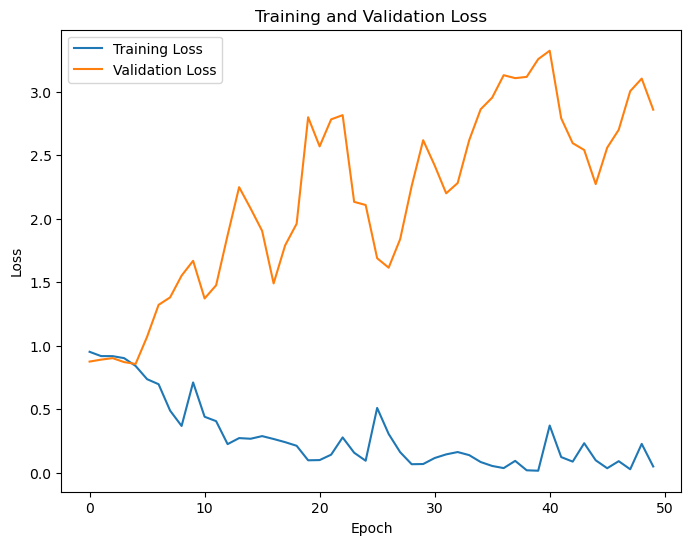

In [230]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [231]:
y_pred= out

In [232]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [233]:
np.unique(features_csv['gender'])

array(['female', 'male'], dtype=object)

In [234]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [235]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [236]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (41,)
Shape of y_test: (41,)
Shape of y_pred: (41,)


In [237]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.04047619047619047


In [238]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.150000
1    0.190476
Name: selection_rate, dtype: float64


In [239]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 1.2698412698412698
0.7875000000000001


## T2

In [278]:
# Example usage
model = MultiModalDeepConvLSTM(
    modality_configs=[(768, 512),(80, 512)],
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

In [279]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

9355393

In [280]:
learning_rate = 0.001
num_epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [281]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [282]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([87, 42])
tensor(2.0714)


In [283]:
from sklearn.metrics import f1_score

# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation F1 score

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    # Training Phase
    for batch in train_dataloader:
        modalities, labels = batch  # Unpack modalities and labels
        optimizer.zero_grad()

        # Concatenate modalities along the feature dimension (if required by the model)
        #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
        output = model(modalities)  # Forward pass through the model

        # Reshape labels to match the output shape
        labels = labels.view(output.shape)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Accumulate training loss
        running_train_loss += loss.item()

        # Convert logits to predictions (assuming binary classification)
        preds = (torch.sigmoid(output) > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch  # Unpack modalities and labels

            # Concatenate modalities along the feature dimension
            #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
            output = model(modalities)  # Forward pass

            # Reshape labels to match the output shape
            labels = labels.view(output.shape)

            # Compute validation loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

            # Convert logits to predictions
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training and validation
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Save the best model based on validation F1-score
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("Best Validation F1", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_multimodal_model_t2_under.pth")  # Save the best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Best Validation F1 0 :  0.520583301071106
Epoch [1/50], Train Loss: 0.9505, Val Loss: 0.8897, Train F1: 0.4270, Val F1: 0.5206
Epoch [2/50], Train Loss: 0.9459, Val Loss: 0.8956, Train F1: 0.3841, Val F1: 0.3997
Best Validation F1 2 :  0.5526343575124063
Epoch [3/50], Train Loss: 0.9294, Val Loss: 0.9005, Train F1: 0.4356, Val F1: 0.5526
Best Validation F1 3 :  0.5984788880146865
Epoch [4/50], Train Loss: 0.9232, Val Loss: 0.8921, Train F1: 0.5440, Val F1: 0.5985
Epoch [5/50], Train Loss: 0.8862, Val Loss: 0.9398, Train F1: 0.7273, Val F1: 0.4344
Epoch [6/50], Train Loss: 0.7812, Val Loss: 1.0432, Train F1: 0.7617, Val F1: 0.5518
Epoch [7/50], Train Loss: 0.7184, Val Loss: 0.9398, Train F1: 0.7263, Val F1: 0.5685
Epoch [8/50], Train Loss: 0.5690, Val Loss: 1.3215, Train F1: 0.7996, Val F1: 0.5951
Epoch [9/50], Train Loss: 0.6300, Val Loss: 1.5253, Train F1: 0.7913, Val F1: 0.4344
Epoch [10/50], Train Loss: 0.5729, Val Loss: 1.2468, Train F1: 0.7958, Val F1: 0.5503
Epoch [11/50], Train 

In [284]:
model.load_state_dict(torch.load("best_multimodal_model_t2_under.pth", weights_only=True))

<All keys matched successfully>

In [285]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.5984788880146865


In [286]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.7647639182522904


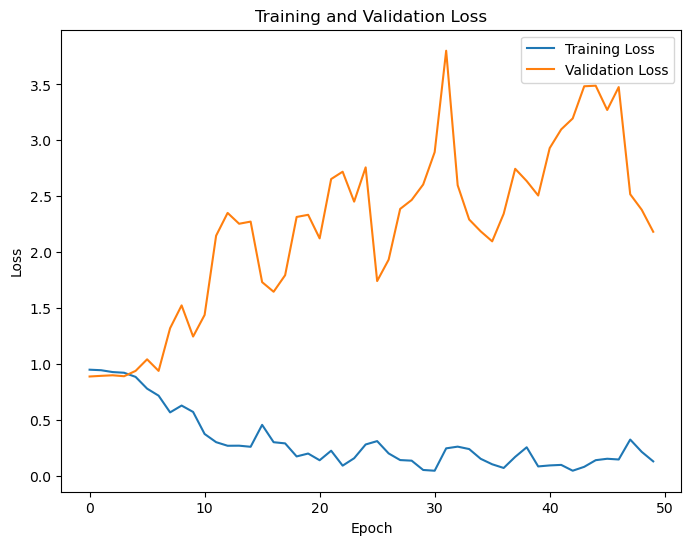

In [287]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [288]:
y_pred= out

In [289]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [290]:
np.unique(features_csv['gender'])

array(['female', 'male'], dtype=object)

In [291]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [292]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [293]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (41,)
Shape of y_test: (41,)
Shape of y_pred: (41,)


In [294]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.17380952380952386


In [295]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.35000
1    0.52381
Name: selection_rate, dtype: float64


In [296]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 1.4965986394557824
0.6681818181818181


## T3

In [297]:
# Example usage
model = MultiModalDeepConvLSTM(
    modality_configs=[(768, 512),(80, 512)],
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

In [298]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

9355393

In [299]:
learning_rate = 0.001
num_epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [300]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [301]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([87, 42])
tensor(2.0714)


In [302]:
from sklearn.metrics import f1_score

# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation F1 score

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    # Training Phase
    for batch in train_dataloader:
        modalities, labels = batch  # Unpack modalities and labels
        optimizer.zero_grad()

        # Concatenate modalities along the feature dimension (if required by the model)
        #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
        output = model(modalities)  # Forward pass through the model

        # Reshape labels to match the output shape
        labels = labels.view(output.shape)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Accumulate training loss
        running_train_loss += loss.item()

        # Convert logits to predictions (assuming binary classification)
        preds = (torch.sigmoid(output) > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch  # Unpack modalities and labels

            # Concatenate modalities along the feature dimension
            #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
            output = model(modalities)  # Forward pass

            # Reshape labels to match the output shape
            labels = labels.view(output.shape)

            # Compute validation loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

            # Convert logits to predictions
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training and validation
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Save the best model based on validation F1-score
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("Best Validation F1", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_multimodal_model_t3_under.pth")  # Save the best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Best Validation F1 0 :  0.6929544437759368
Epoch [1/50], Train Loss: 0.9447, Val Loss: 0.8638, Train F1: 0.5219, Val F1: 0.6930
Epoch [2/50], Train Loss: 0.9416, Val Loss: 0.8792, Train F1: 0.5386, Val F1: 0.6238
Epoch [3/50], Train Loss: 0.9139, Val Loss: 0.8926, Train F1: 0.6589, Val F1: 0.6427
Epoch [4/50], Train Loss: 0.8325, Val Loss: 0.9132, Train F1: 0.7070, Val F1: 0.6208
Epoch [5/50], Train Loss: 0.7175, Val Loss: 1.0214, Train F1: 0.7431, Val F1: 0.5474
Epoch [6/50], Train Loss: 0.6092, Val Loss: 1.3394, Train F1: 0.8024, Val F1: 0.5685
Epoch [7/50], Train Loss: 0.4886, Val Loss: 1.5060, Train F1: 0.8752, Val F1: 0.4443
Epoch [8/50], Train Loss: 0.5107, Val Loss: 1.4032, Train F1: 0.8474, Val F1: 0.5807
Epoch [9/50], Train Loss: 0.4680, Val Loss: 1.4984, Train F1: 0.8485, Val F1: 0.5055
Epoch [10/50], Train Loss: 0.7167, Val Loss: 1.1404, Train F1: 0.8127, Val F1: 0.5871
Epoch [11/50], Train Loss: 0.5581, Val Loss: 1.2964, Train F1: 0.8248, Val F1: 0.5046
Epoch [12/50], Train

In [303]:
model.load_state_dict(torch.load("best_multimodal_model_t3_under.pth", weights_only=True))

<All keys matched successfully>

In [304]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.6929544437759368


In [305]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.5467269595176572


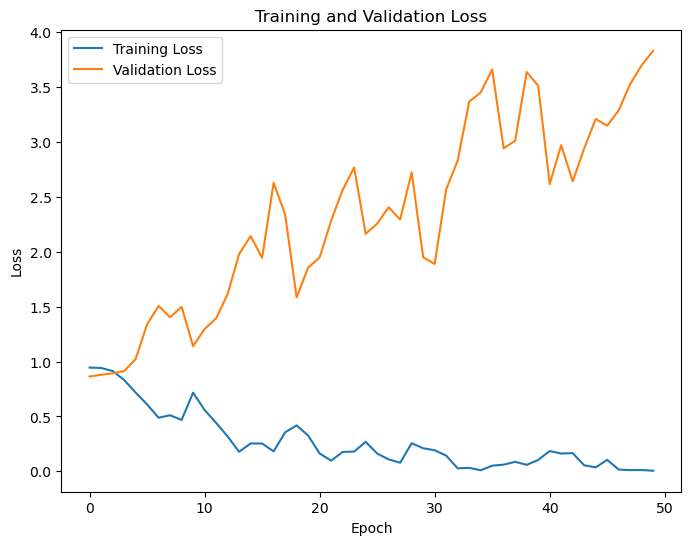

In [306]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [307]:
y_pred= out

In [308]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [309]:
np.unique(features_csv['gender'])

array(['female', 'male'], dtype=object)

In [310]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [311]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [312]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (41,)
Shape of y_test: (41,)
Shape of y_pred: (41,)


In [313]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.11904761904761907


In [314]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.500000
1    0.380952
Name: selection_rate, dtype: float64


In [315]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 0.7619047619047619


## T4

In [318]:
# Example usage
model = MultiModalDeepConvLSTM(
    modality_configs=[(768, 64),(80, 64)],
    lstm_hidden_size=128, 
    lstm_layers=2, 
    output_size=1, 
    dropout=0.5
)

In [319]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

827265

In [320]:
learning_rate = 0.001
num_epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [321]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["PTSD_label"].values)

For example, if a dataset contains 100 positive and 300 negative examples of a single class, then pos_weight for the class should be equal to 300/100=3. The loss would act as if the dataset contains 3×100=300 positive examples.

In [322]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
print(class_counts)
class_weight = class_counts[0] / class_counts[1]
print(class_weight)
# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # Weight for positive class


tensor([87, 42])
tensor(2.0714)


In [323]:
from sklearn.metrics import f1_score

# Define variables to track losses
train_losses = []
val_losses = []
best_dev_f1 = float('-inf')  # Initialize best validation F1 score

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    # Training Phase
    for batch in train_dataloader:
        modalities, labels = batch  # Unpack modalities and labels
        optimizer.zero_grad()

        # Concatenate modalities along the feature dimension (if required by the model)
        #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
        output = model(modalities)  # Forward pass through the model

        # Reshape labels to match the output shape
        labels = labels.view(output.shape)

        # Compute loss
        loss = criterion(output, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Accumulate training loss
        running_train_loss += loss.item()

        # Convert logits to predictions (assuming binary classification)
        preds = (torch.sigmoid(output) > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch  # Unpack modalities and labels

            # Concatenate modalities along the feature dimension
            #inputs = torch.cat(modalities, dim=-1)  # Shape: (batch_size, time_steps, combined_features)
            output = model(modalities)  # Forward pass

            # Reshape labels to match the output shape
            labels = labels.view(output.shape)

            # Compute validation loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

            # Convert logits to predictions
            preds = (torch.sigmoid(output) > 0.5).int()
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Compute F1-score for training and validation
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Save the best model based on validation F1-score
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        print("Best Validation F1", epoch, ": ", best_dev_f1)
        torch.save(model.state_dict(), "best_multimodal_model_t4_under.pth")  # Save the best model

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Best Validation F1 0 :  0.5870774497218656
Epoch [1/50], Train Loss: 0.9366, Val Loss: 0.8863, Train F1: 0.5030, Val F1: 0.5871
Epoch [2/50], Train Loss: 0.9365, Val Loss: 0.8864, Train F1: 0.5584, Val F1: 0.5300
Best Validation F1 2 :  0.5984788880146865
Epoch [3/50], Train Loss: 0.9158, Val Loss: 0.9016, Train F1: 0.7140, Val F1: 0.5985
Epoch [4/50], Train Loss: 0.8148, Val Loss: 0.9682, Train F1: 0.6996, Val F1: 0.5474
Epoch [5/50], Train Loss: 0.6656, Val Loss: 1.3587, Train F1: 0.7719, Val F1: 0.5040
Epoch [6/50], Train Loss: 0.6210, Val Loss: 1.4134, Train F1: 0.7963, Val F1: 0.4443
Epoch [7/50], Train Loss: 0.4292, Val Loss: 1.7050, Train F1: 0.8686, Val F1: 0.4998
Epoch [8/50], Train Loss: 0.4059, Val Loss: 2.0623, Train F1: 0.9075, Val F1: 0.4818
Epoch [9/50], Train Loss: 0.3242, Val Loss: 2.1774, Train F1: 0.9162, Val F1: 0.5040
Epoch [10/50], Train Loss: 0.2410, Val Loss: 2.0951, Train F1: 0.9376, Val F1: 0.5701
Epoch [11/50], Train Loss: 0.3211, Val Loss: 1.8111, Train F1: 

In [324]:
model.load_state_dict(torch.load("best_multimodal_model_t4_under.pth", weights_only=True))

<All keys matched successfully>

In [325]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.5984788880146865


In [326]:
# Model prediction
model.eval()  # Set model to evaluation mode
lab = []
predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        _data, labels = batch
        output = model(_data)  # Model's prediction
        
        predicts = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)
        predictions.append(predicted_classes)
        lab.append(labels)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out_train = np.concatenate(predictions).ravel()
labels = np.concatenate(lab).ravel()
dev_f1 = f1_score(labels, out_train, average='weighted')
print(f"Predictions:\n{np.unique(out)}")
print(f"Labels:\n{np.unique(labels)}")
print(dev_f1)

Predictions:
[0 1]
Labels:
[0. 1.]
0.7727217870892217


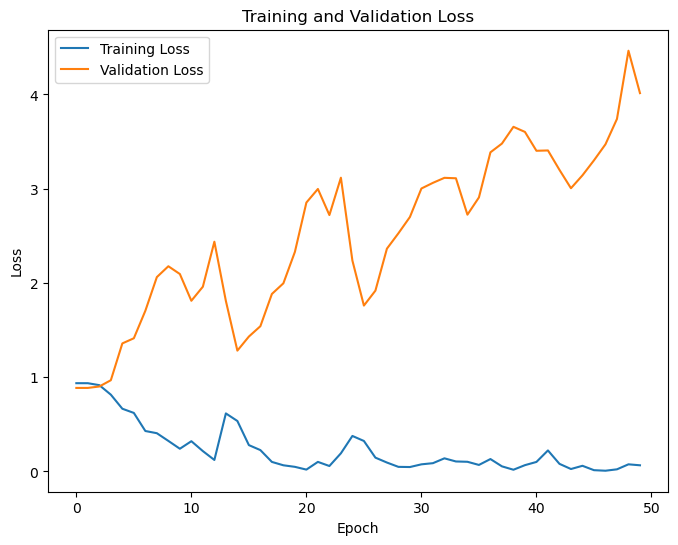

In [327]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [328]:
y_pred= out

In [329]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_label"].values)

In [330]:
np.unique(features_csv['gender'])

array(['female', 'male'], dtype=object)

In [331]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [332]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [333]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="dev"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (41,)
Shape of y_test: (41,)
Shape of y_pred: (41,)


In [334]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.021428571428571463


In [335]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.450000
1    0.428571
Name: selection_rate, dtype: float64


In [336]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")
    if demographic_parity_ratio>1:
        print(1/demographic_parity_ratio)

Demographic Parity Ratio: 0.9523809523809523
